<a href="https://colab.research.google.com/github/DevanshPatel234/FMML_Project_and_Labs/blob/main/Implementation%20of%20CNN%20using%20Pytorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Convolutional Neural Network (CNN) using PyTorch

## Introduction

Convolutional Neural Networks (CNNs) are a class of deep neural networks commonly used in image and video recognition tasks. They are particularly effective for spatial data due to their ability to capture local patterns and hierarchical features.

## Key Concepts

- **Convolutional Layers:** These layers apply a convolution operation to the input, passing the result to the next layer. They are responsible for detecting local features such as edges, textures, and shapes.
- **Pooling Layers:** These layers reduce the spatial dimensions of the input, retaining important information while discarding less important details. Common pooling operations include max pooling and average pooling.
- **Fully Connected Layers:** After several convolutional and pooling layers, the high-level reasoning in the network is done via fully connected layers.
- **Activation Functions:** Non-linear functions such as ReLU are applied to introduce non-linearity into the network, enabling it to learn complex patterns.

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
# Loading and prepparing the data
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 30572688.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
batchSize = 200

trainset, validateset = random_split(dataset, [45000, 5000])

train = DataLoader(trainset, batchSize, shuffle=True)
validate = DataLoader(validateset, batchSize, shuffle=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

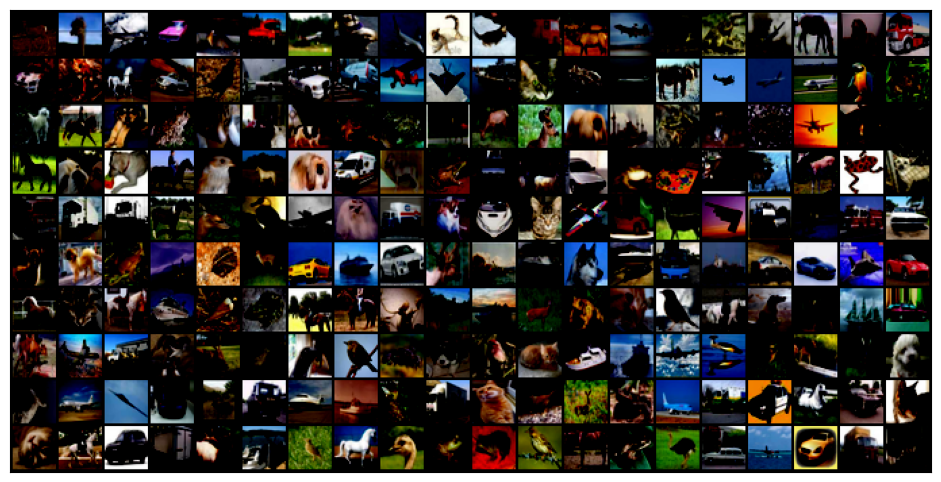

In [5]:
# Display some of the images
for images, labels in train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

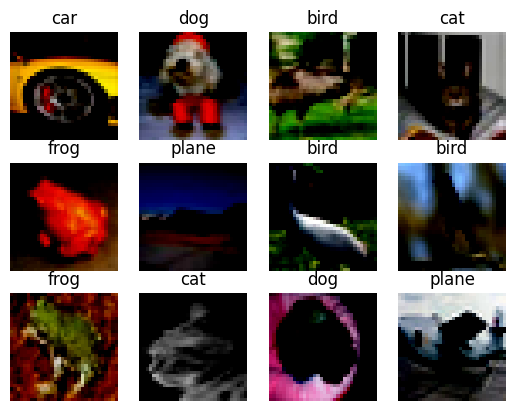

In [6]:
for i in range(0, 12):
    img, label = validateset[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

In [7]:
# Creating the CNN Classification Model class
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(

            # here we define 3 channels as our inpur, 32 channels as the output,
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch):
        # unpack the images and labels from the
        images, labels = batch

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

In [8]:
# Training the CNN classification model
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [9]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    optimizer = optimizationFunction(model.parameters(), lr)

    for epoch in range(epochs):
        print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainingLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")

In [10]:
# instantiate the model
model = Cifar10Classifier()
# do an evaluation of the model on the tra
evaluateModel(model, validate)

{'loss': 2.3026692867279053, 'accuracy': 0.0998000055551529}

In [11]:
%%time
trainModel(6, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

training epoch 0
after training epoch 0 we get results {'loss': 1.4709370136260986, 'accuracy': 0.46399998664855957}
training epoch 1
after training epoch 1 we get results {'loss': 1.0944234132766724, 'accuracy': 0.6123999953269958}
training epoch 2
after training epoch 2 we get results {'loss': 0.9300406575202942, 'accuracy': 0.6744000315666199}
training epoch 3
after training epoch 3 we get results {'loss': 0.8018537759780884, 'accuracy': 0.7151999473571777}
training epoch 4
after training epoch 4 we get results {'loss': 0.6904596090316772, 'accuracy': 0.7630000114440918}
training epoch 5
after training epoch 5 we get results {'loss': 0.6928060054779053, 'accuracy': 0.7683999538421631}
CPU times: user 1h 28min 37s, sys: 1min 50s, total: 1h 30min 28s
Wall time: 1h 31min 20s


In [12]:
#Predicting the imagge class with our trainned model
print(f"validation dataset accuracy: {evaluateModel(model, validate)}")

validation dataset accuracy: {'loss': 0.6928060054779053, 'accuracy': 0.7684000134468079}


In [13]:
print(f"test dataset accuracy: {evaluateModel(model, testLoader)}")

test dataset accuracy: {'loss': 0.7128515839576721, 'accuracy': 0.7604999542236328}


In [14]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

<ipython-input-15-a5fe4aa16f27>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i + 1)


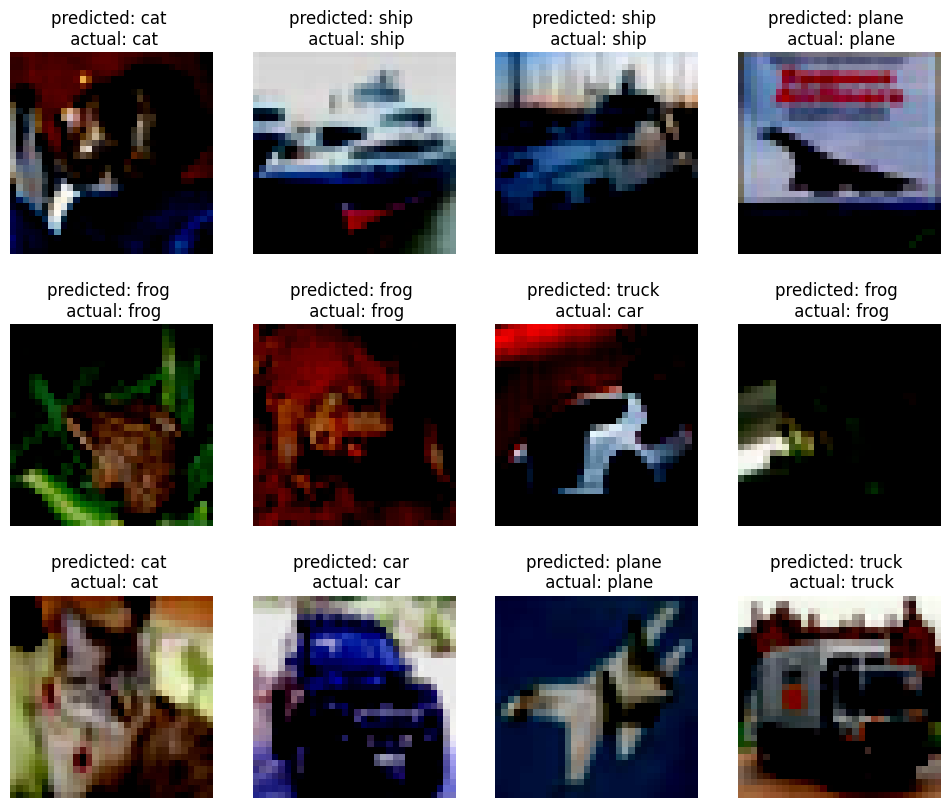

In [15]:
with torch.no_grad():

    plt.subplots(figsize=(12, 10))

    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)


        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))

In [16]:
# Confusion matrix
predictions = np.empty((0, len(testset)), np.int32)
actualValues = np.empty((0, len(testset)), np.int32)

with torch.no_grad():
    for i in range(0, len(testset)):
        testImg, testLabel = testset[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)

<Axes: >

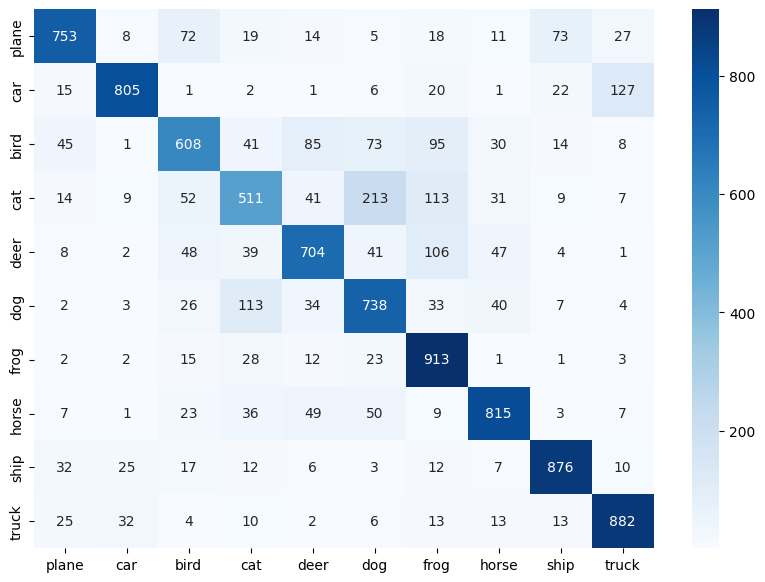

In [17]:
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')